# SAM 3 — Segment Anything Model 3 (Image Segmentation)

Text-prompted instance segmentation using the SAM 3 model.

**Steps:**
1. Import dependencies
2. Define helper functions
3. Set hyperparameters (input path, output path, prompt, etc.) and run

## 1 — Imports

In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import Sam3Model, Sam3Processor

# Repo root (two levels up from analysis/tutorials/)
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

%matplotlib inline

## 2 — Helper Functions

In [2]:
def load_model(model_name="facebook/sam3"):
    """Load SAM 3 model and processor onto GPU (or CPU fallback)."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading model: {model_name} on {device} ...")
    model = Sam3Model.from_pretrained(model_name).to(device)
    processor = Sam3Processor.from_pretrained(model_name)
    print("Model and processor loaded successfully!")
    return model, processor, device


def run_segmentation(model, processor, image, text_prompt, device, threshold=0.5):
    """Run SAM 3 text-prompted segmentation on a PIL image.
    
    Returns post-processed results dict with 'masks' and 'scores'.
    """
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    print(f"Running inference with prompt: '{text_prompt}' ...")
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_instance_segmentation(
        outputs, threshold=threshold, target_sizes=[image.size[::-1]]
    )[0]
    num_objects = len(results['masks'])
    scores = results['scores'].cpu().numpy()
    print(f"Detected {num_objects} object(s) — scores: {scores}")
    return results


def visualize_and_save(image, results, text_prompt, output_dir, alpha=0.45):
    """Visualize masks, overlay on original image, and save all results to disk."""
    masks  = results['masks']
    scores = results['scores'].cpu().numpy()
    num_masks = len(masks)

    if num_masks == 0:
        print("No masks detected.")
        return

    # --- Individual mask gallery ---
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(6 * (num_masks + 1), 6))
    if num_masks + 1 == 1:
        axes = [axes]
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    for i, mask in enumerate(masks):
        mask_np = (mask.cpu().numpy() * 255).astype(np.uint8)
        axes[i + 1].imshow(mask_np, cmap="gray")
        axes[i + 1].set_title(f"Mask {i} — score {scores[i]:.3f}")
        axes[i + 1].axis("off")
    plt.tight_layout()
    plt.show()

    # --- Colour overlay ---
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
    overlay = np.array(image).copy()
    for i, mask in enumerate(masks):
        mask_bool = mask.cpu().numpy().astype(bool)
        color = colors[i % len(colors)]
        for c in range(3):
            overlay[:, :, c] = np.where(
                mask_bool,
                overlay[:, :, c] * (1 - alpha) + color[c] * alpha,
                overlay[:, :, c],
            )
    plt.figure(figsize=(10, 8))
    plt.imshow(overlay)
    plt.title(f"SAM 3 — '{text_prompt}' overlay ({num_masks} object(s))")
    plt.axis("off")
    plt.show()

    # --- Save to disk ---
    os.makedirs(output_dir, exist_ok=True)
    overlay_img = Image.fromarray(overlay.astype(np.uint8))
    overlay_path = os.path.join(output_dir, "overlay.png")
    overlay_img.save(overlay_path)
    print(f"Saved overlay → {overlay_path}")
    for i, mask in enumerate(masks):
        mask_np = (mask.cpu().numpy() * 255).astype(np.uint8)
        mask_path = os.path.join(output_dir, f"mask_{i}.png")
        Image.fromarray(mask_np, mode="L").save(mask_path)
        print(f"Saved mask {i} → {mask_path}")
    print("Done!")

def run_segmentation(model, processor, image, text_prompt, device, threshold=0.5):
    """Run SAM 3 text-prompted segmentation on a PIL image.
    
    Returns post-processed results dict with 'masks' and 'scores'.
    """
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    print(f"Running inference with prompt: '{text_prompt}' ...")
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_instance_segmentation(
        outputs, threshold=threshold, target_sizes=[image.size[::-1]]
    )[0]
    num_objects = len(results['masks'])
    scores = results['scores'].cpu().numpy()
    print(f"Detected {num_objects} object(s) — scores: {scores}")
    return results

## 3 — Run Segmentation
Set your input/output paths and prompt below, then run the cell.

Loading model: facebook/sam3 on cuda ...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Model and processor loaded successfully!
Loaded image: /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/data/sam3/frame_000013.png  size=(1920, 1080)


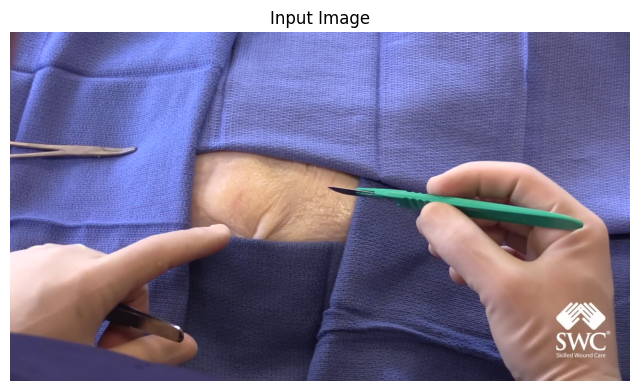

Running inference with prompt: 'skin' ...
Detected 3 object(s) — scores: [0.57395625 0.51217586 0.6948204 ]


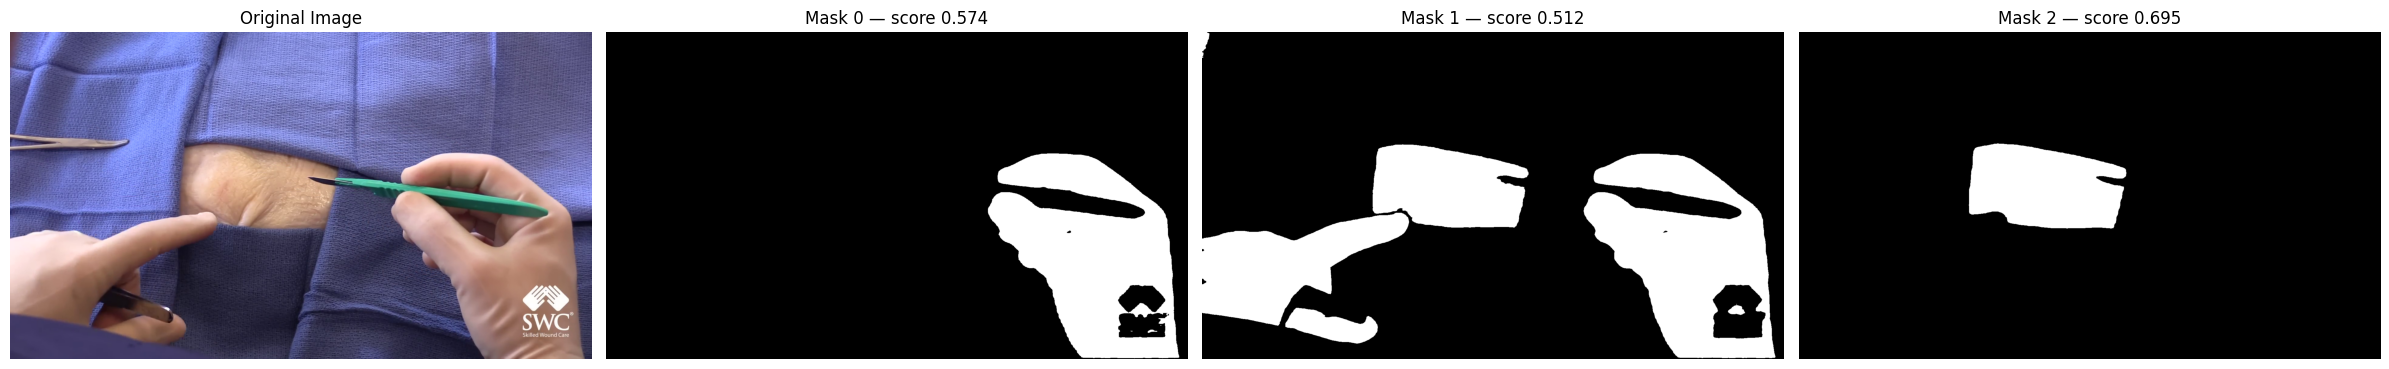

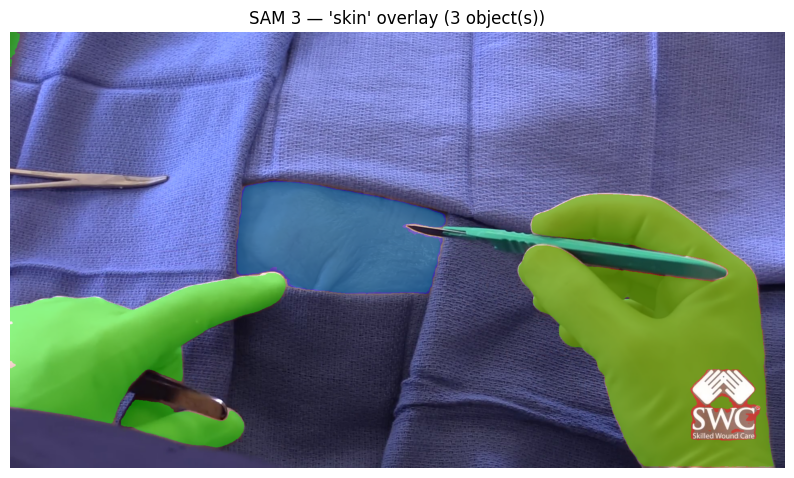

Saved overlay → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/frame_000013/overlay.png
Saved mask 0 → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/frame_000013/mask_0.png
Saved mask 1 → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/frame_000013/mask_1.png
Saved mask 2 → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/frame_000013/mask_2.png
Done!


/tmp/ipykernel_761882/1604627994.py:81: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(mask_np, mode="L").save(mask_path)


In [3]:
# ---- Hyperparameters (paths relative to repo root) ------------------
input_path   = "analysis/data/sam3/frame_000013.png"    # input image
output_dir   = "analysis/outputs/sam3/frame_000013"     # output folder
model_name   = "facebook/sam3"                        # HF model id
text_prompt  = "skin"                                  # what to detect
threshold    = 0.5                                    # confidence threshold
alpha        = 0.45                                   # overlay transparency
# ---------------------------------------------------------------------

input_path  = os.path.join(ROOT, input_path)
output_dir  = os.path.join(ROOT, output_dir)

# Load model
model, processor, device = load_model(model_name)

# Load image
image = Image.open(input_path).convert("RGB")
print(f"Loaded image: {input_path}  size={image.size}")
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")
plt.show()

# Run segmentation & visualize
results = run_segmentation(model, processor, image, text_prompt, device, threshold)
visualize_and_save(image, results, text_prompt, output_dir, alpha)

Loading model: facebook/sam3 on cuda ...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Model and processor loaded successfully!
Loaded image: /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/data/sam3/frame_000013.png  size=(1920, 1080)


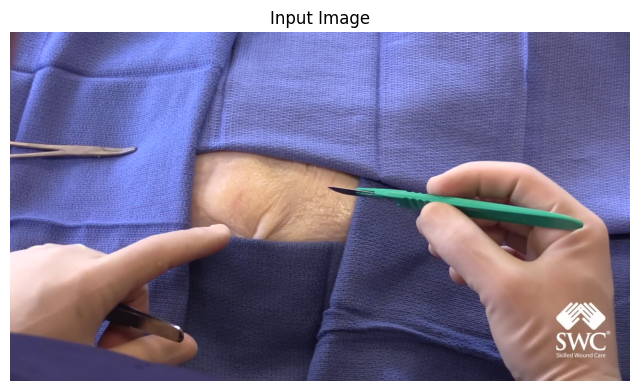

Running inference with prompt: 'blade' ...
Detected 1 object(s) — scores: [0.811816]


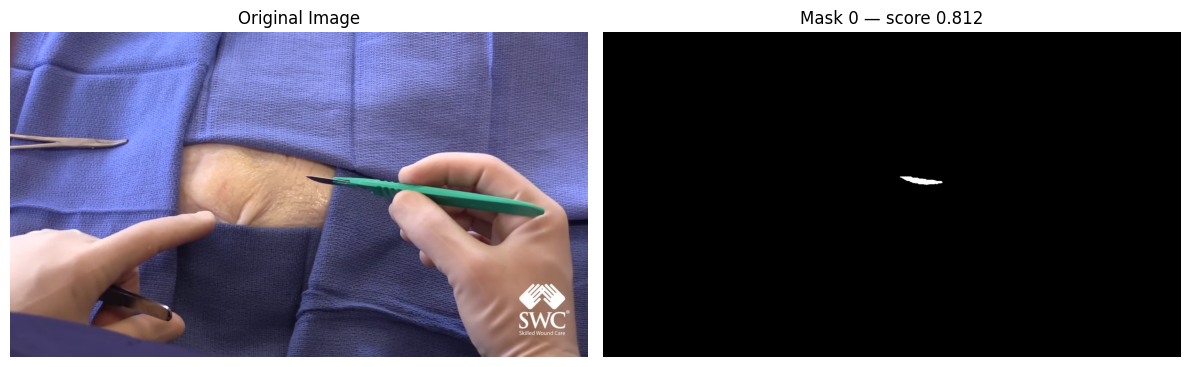

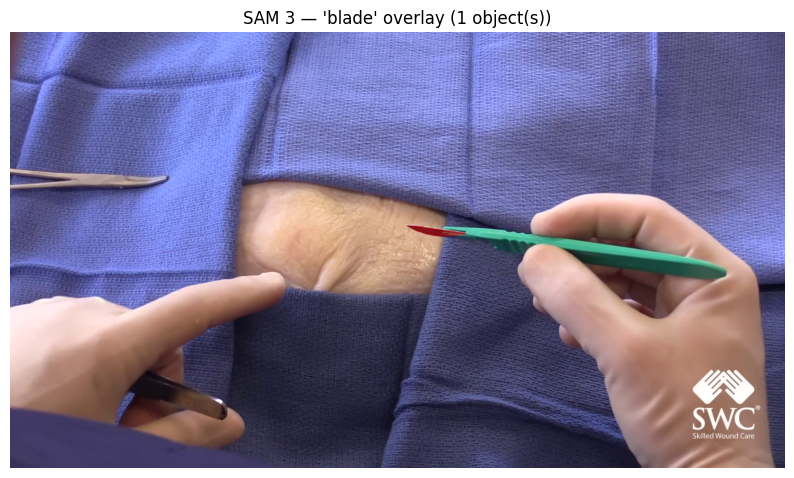

Saved overlay → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/frame_000013/overlay.png
Saved mask 0 → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/frame_000013/mask_0.png
Done!


/tmp/ipykernel_761882/1604627994.py:81: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(mask_np, mode="L").save(mask_path)


In [4]:
# ---- Hyperparameters (paths relative to repo root) ------------------
input_path   = "analysis/data/sam3/frame_000013.png"    # input image
output_dir   = "analysis/outputs/sam3/frame_000013"     # output folder
model_name   = "facebook/sam3"                        # HF model id
text_prompt  = "blade"                                  # what to detect
threshold    = 0.5                                    # confidence threshold
alpha        = 0.45                                   # overlay transparency
# ---------------------------------------------------------------------

input_path  = os.path.join(ROOT, input_path)
output_dir  = os.path.join(ROOT, output_dir)

# Load model
model, processor, device = load_model(model_name)

# Load image
image = Image.open(input_path).convert("RGB")
print(f"Loaded image: {input_path}  size={image.size}")
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")
plt.show()

# Run segmentation & visualize
results = run_segmentation(model, processor, image, text_prompt, device, threshold)
visualize_and_save(image, results, text_prompt, output_dir, alpha)

## 4 — Load Model & Set Constants (run once)

In [5]:
# ---- Constant hyperparameters (change once, not per image) ----------
model_name   = "facebook/sam3"                        # HF model id
text_prompt  = "foreceps"                                 # what to detect
threshold    = 0.5                                    # confidence threshold
alpha        = 0.45                                   # overlay transparency
# ---------------------------------------------------------------------

model, processor, device = load_model(model_name)

Loading model: facebook/sam3 on cuda ...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Model and processor loaded successfully!


In [12]:
text_prompt  = "tweezer" 

## 5 — Run on New Image (change `input_path` and re-run this cell)

Loaded image: /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/data/sam3/image.png  size=(963, 568)


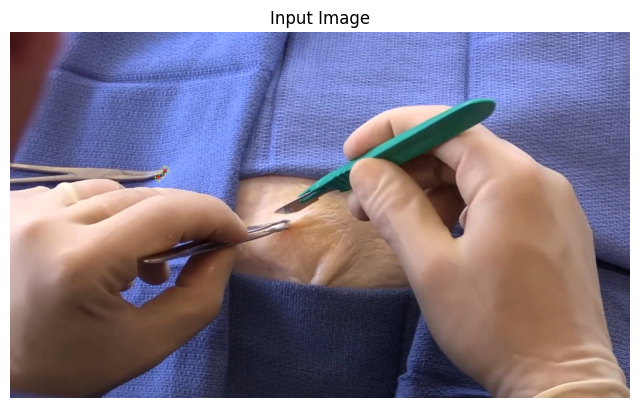

Running inference with prompt: 'tweezer' ...
Detected 3 object(s) — scores: [0.955787  0.931855  0.9794647]


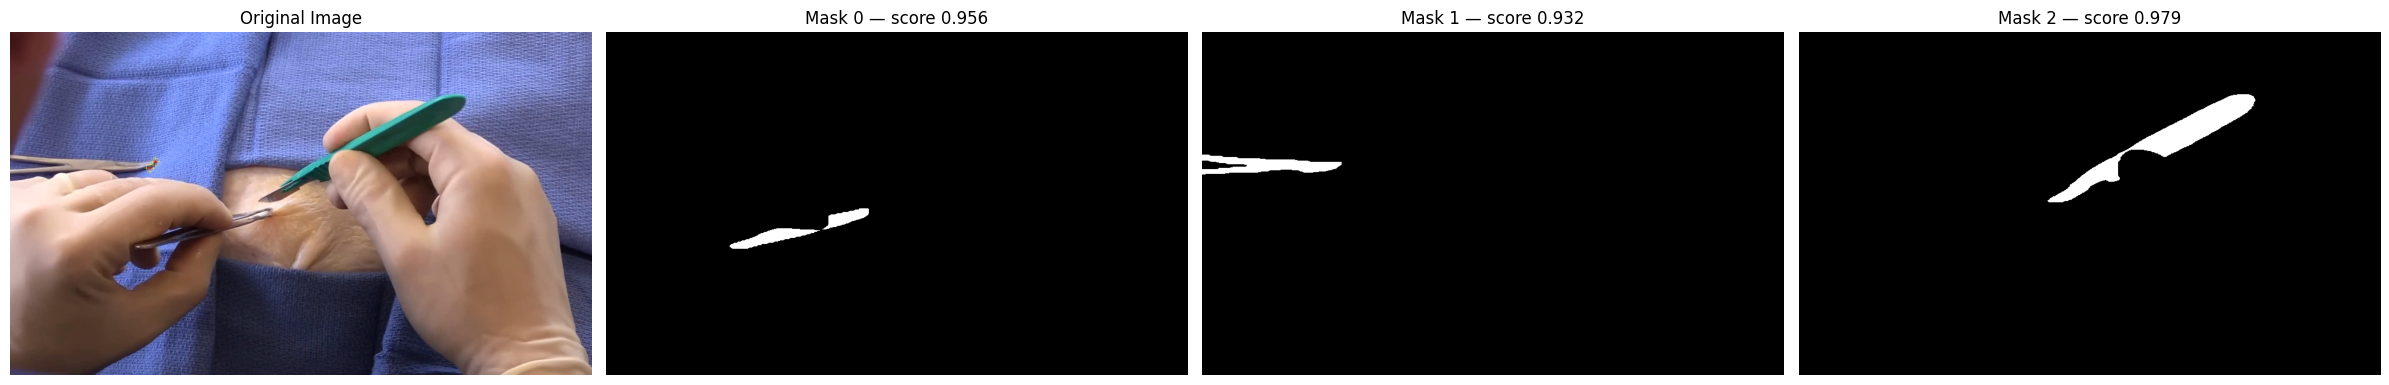

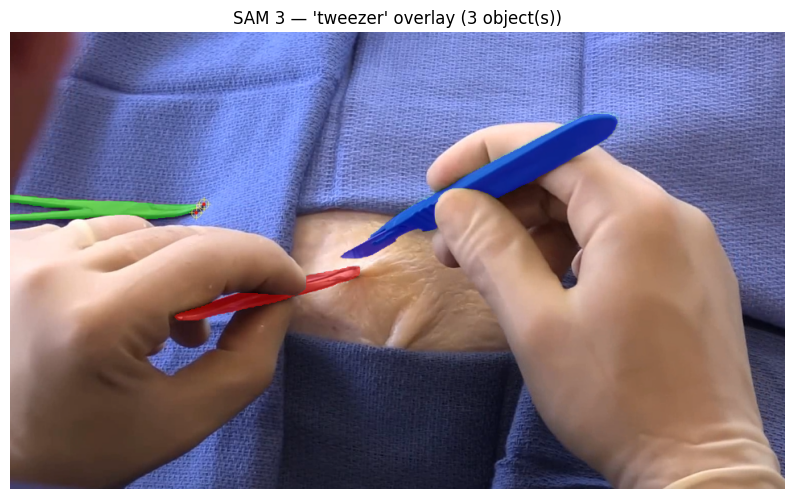

Saved overlay → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/image/overlay.png
Saved mask 0 → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/image/mask_0.png
Saved mask 1 → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/image/mask_1.png
Saved mask 2 → /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/sam3/image/mask_2.png
Done!

⏱  Segmentation took 0.692 s


/tmp/ipykernel_761882/1604627994.py:81: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(mask_np, mode="L").save(mask_path)


In [13]:
# ---- Change this per run --------------------------------------------
input_path   = "analysis/data/sam3/image.png"    # input image
output_dir   = "analysis/outputs/sam3/image"     # output folder
# ---------------------------------------------------------------------

input_path  = os.path.join(ROOT, input_path)
output_dir  = os.path.join(ROOT, output_dir)

image = Image.open(input_path).convert("RGB")
print(f"Loaded image: {input_path}  size={image.size}")
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")
plt.show()

import time
t0 = time.time()
results = run_segmentation(model, processor, image, text_prompt, device, threshold)
seg_time = time.time() - t0

visualize_and_save(image, results, text_prompt, output_dir, alpha)
print(f"\n⏱  Segmentation took {seg_time:.3f} s")